In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import sys
from PIL import Image
sys.path.append('../../models/')
sys.path.append('../../dataset')
#from unet import UNet
import torch
from dataset import AsbestosDataSet
import albumentations as A
from torch.utils.data import DataLoader, ConcatDataset, Subset
import pandas as pd
import torch

In [17]:
def show_instance(dataset_instance, metadata = None, predictor=None, scale = 0.25, vebose = True):
    '''
    show data, meta_data and predicted values
    '''
    if vebose:
        print(dataset_instance["file_name"])
    
    outputs = []
    
    img = cv2.imread(dataset_instance["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=scale,
                            instance_mode = ColorMode.IMAGE_BW)

    #ORIGINAL    
    out = visualizer.get_output()
    print('\n ORIGINAL') 
    cv2_imshow(out.get_image()[:, :, ::-1])

    if metadata is not None:
        #GROUNDTRUCH
        out = visualizer.draw_dataset_dict(dataset_instance)
        print('\n GROUNDTRUCH')        
        cv2_imshow(out.get_image()[:, :, ::-1])

    #PREDICTED
    if predictor is not None:
        #I DO NOT KNOW WHY,
        # BUT IT IS NECESSARY TO CREATE NEW INSTANCE OF Visualizer
        visualizer = Visualizer(img[:, :, ::-1], 
                                metadata=metadata, 
                                scale=scale,
                                instance_mode = ColorMode.IMAGE_BW)  
      
        outputs = predictor(img[:, :, ::-1])

        out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

        print('\n PREDICTED')    
        cv2_imshow(out.get_image()[:, :, ::-1])
    
    return [outputs]


In [2]:
torch.cuda.is_available()

True

In [31]:
image_size = 512
s1_validation_set = AsbestosDataSet('../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/validation/images',
                            '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/validation/masks',
     A.Compose([A.Resize(1152, 1728), A.RandomCrop(1024,1024), A.Resize(image_size,image_size)]))
data_loader = DataLoader(s1_validation_set)

In [91]:
s1_validation_set[3]

{'image': array([[0.91568625, 0.9166666 , 0.91568625, ..., 0.9470588 , 0.9519608 ,
         0.9558823 ],
        [0.91568625, 0.91764706, 0.91764706, ..., 0.9588235 , 0.9558824 ,
         0.95392156],
        [0.9166666 , 0.91764706, 0.9186275 , ..., 0.9705882 , 0.9676471 ,
         0.9558823 ],
        ...,
        [0.85294116, 0.8519608 , 0.85392153, ..., 0.8686274 , 0.8686274 ,
         0.8696078 ],
        [0.85392153, 0.85294116, 0.85      , ..., 0.87058824, 0.87058824,
         0.8686274 ],
        [0.84803927, 0.85490197, 0.85392153, ..., 0.87058824, 0.8696078 ,
         0.8715687 ]], dtype=float32),
 'mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'path': 'IMG_2734.png'}

In [110]:
os.listdir('../logs/unet_lab_log_2022-01-27 23:40:50.743658/checkpoints/')

['best.pth',
 'last_full.pth',
 'train.300.pth',
 '_metrics.json',
 'last.pth',
 'best_full.pth',
 'train.300_full.pth']

In [120]:
unet = UNet(n_channels=1, n_classes = 1 )
state = torch.load('../logs/unet_lab_log_2022-01-27 15:20:55.861210/checkpoints/train.300.pth',map_location = torch.device('cuda'))
unet.load_state_dict(state['model_state_dict'],)
unet = unet.to('cuda')

In [121]:
next(iter(data_loader))

{'image': tensor([[[0.7755, 0.7696, 0.7676,  ..., 0.8706, 0.8696, 0.8716],
          [0.7755, 0.7716, 0.7667,  ..., 0.8706, 0.8735, 0.8725],
          [0.7706, 0.7676, 0.7696,  ..., 0.8696, 0.8706, 0.8696],
          ...,
          [0.9324, 0.9373, 0.9333,  ..., 0.8941, 0.8961, 0.8971],
          [0.9314, 0.9363, 0.9333,  ..., 0.8941, 0.8951, 0.8961],
          [0.9324, 0.9294, 0.9333,  ..., 0.8961, 0.8980, 0.8971]]]),
 'mask': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32),
 'path': ['IMG_2731.png']}

['IMG_2731.png']
torch.Size([1, 1, 512, 512])


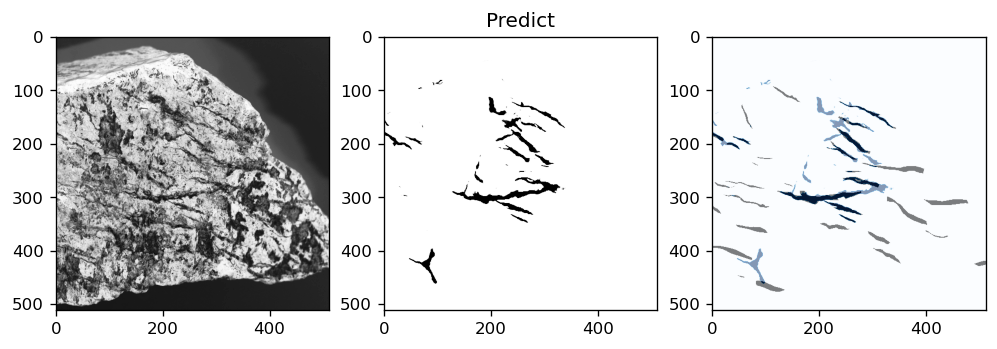

In [122]:
ex = next(data_loader.__iter__())
image = ex['image']
mask  = ex['mask']
print(ex['path'])
image = image.unsqueeze(1)
print(image.shape)
out = unet(image.to('cuda'))
pred_mask  = out[0][0].detach().cpu().numpy() 

fig, ax = plt.subplots(1,3, figsize = (10,10), dpi = 120)
ax[0].imshow(image[0][0].detach().cpu().numpy(), cmap='Greys')
ax[1].imshow(pred_mask, cmap='Greys')
ax[1].set_title('Predict')
ax[2].imshow(mask[0].detach().cpu().numpy(), cmap='Greys')
ax[2].imshow(pred_mask, alpha=0.5, cmap = 'Blues')

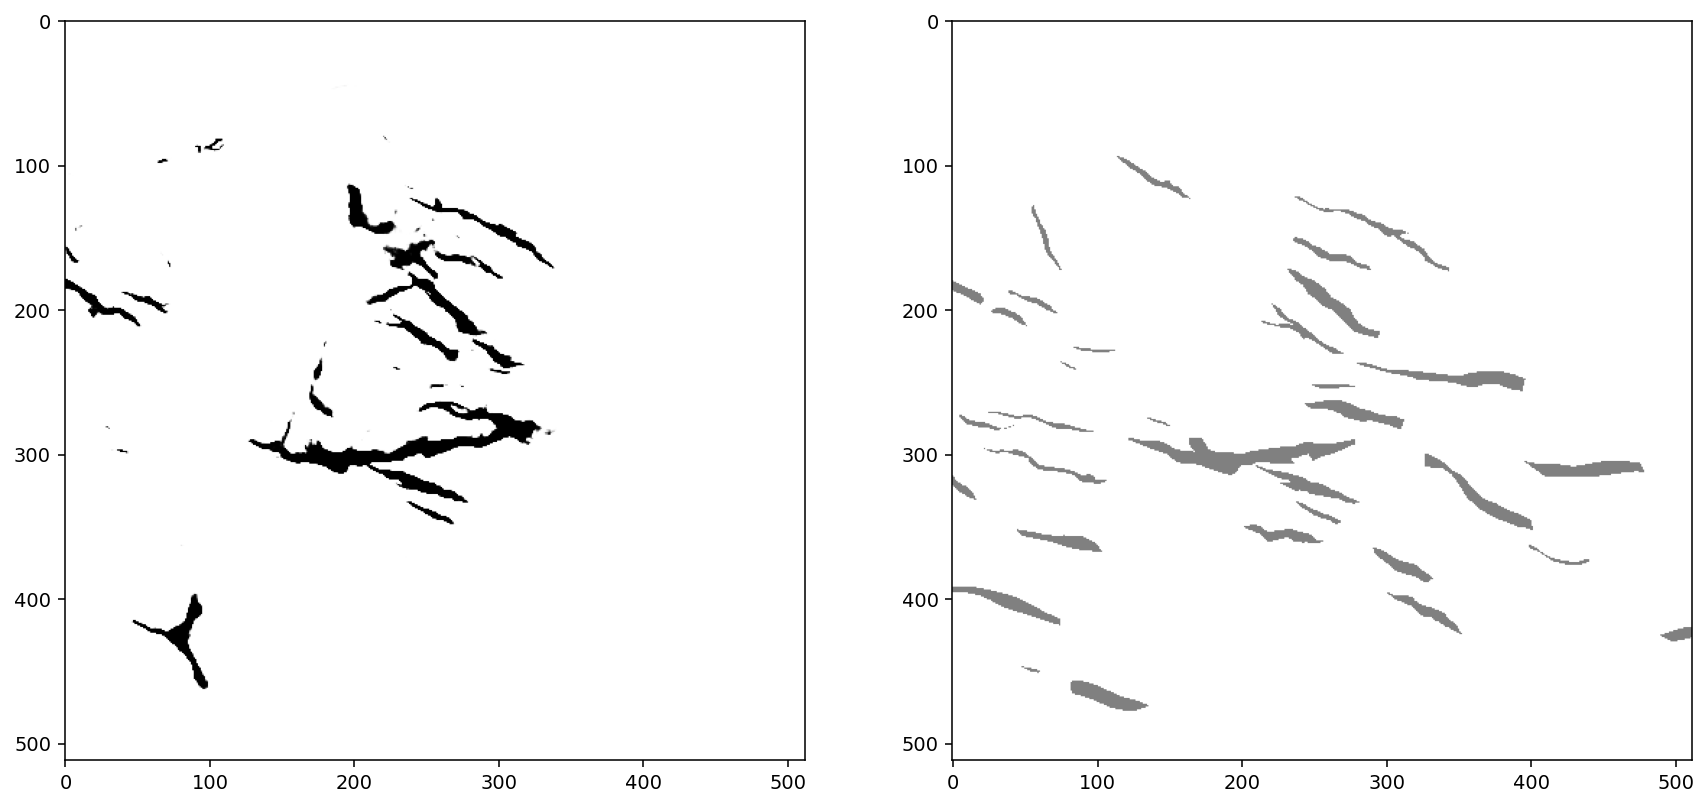

In [123]:
fig, ax = plt.subplots(1,2, figsize = (15,15), dpi = 140)
ax[0].imshow(pred_mask, cmap='Greys')
ax[1].imshow(mask[0].detach().cpu().numpy(), cmap='Greys', alpha = 0.5)

In [4]:
os.listdir('../logs/')

['unet_lab_log_2022-01-27 23:40:50.743658',
 '.ipynb_checkpoints',
 'unet_lab_log_2022-01-29 12:22:32.417023',
 'unet_lab_log_2022-01-27 15:20:55.861210']

Text(0.5, 1.0, 'IOU train')

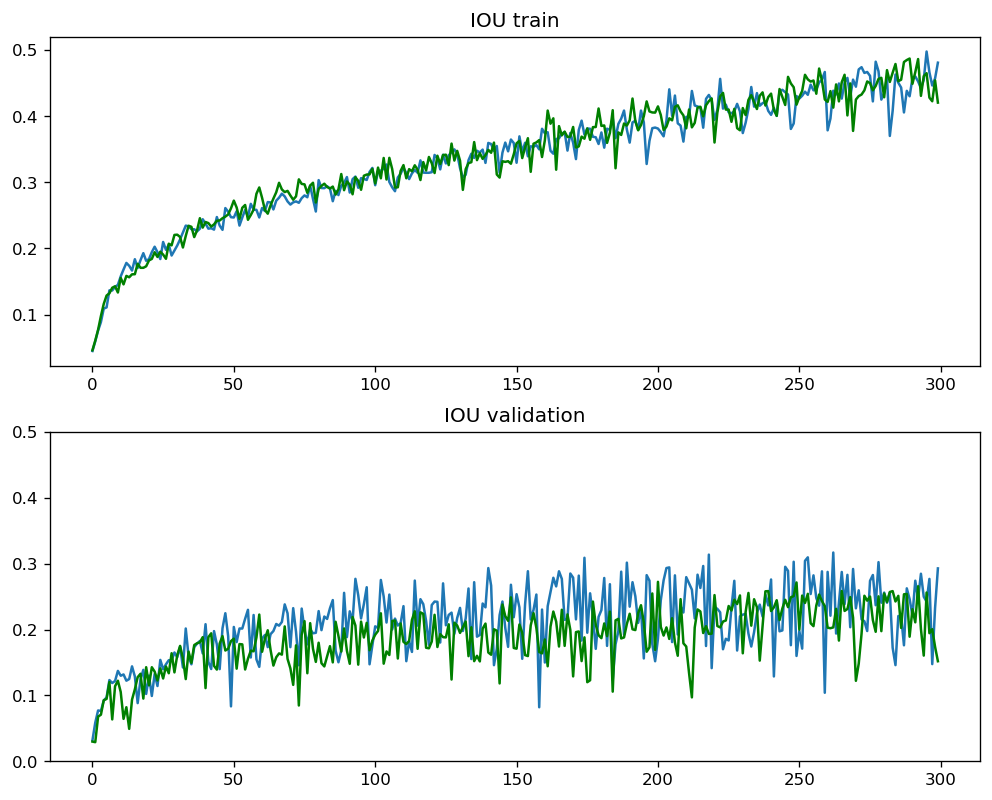

In [61]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, dpi = 120, figsize=(10,8))

frame = pd.read_csv('../logs/2_set_att_unet/logs/train.csv')
axes[0].plot(frame['iou'])
frame = pd.read_csv('../logs/2_set_unet/logs/train.csv')
axes[0].plot(frame['iou'],'green')


frame = pd.read_csv('../logs/2_set_att_unet/logs/valid.csv')
axes[1].plot(frame['iou'])
frame = pd.read_csv('../logs/2_set_unet/logs/valid.csv')
axes[1].plot(frame['iou'],'green')
axes[1].set(ylim=(0, 0.5))

axes[1].set_title('IOU validation')
axes[0].set_title('IOU train')

In [62]:
fig.savefig('iou.jpeg')

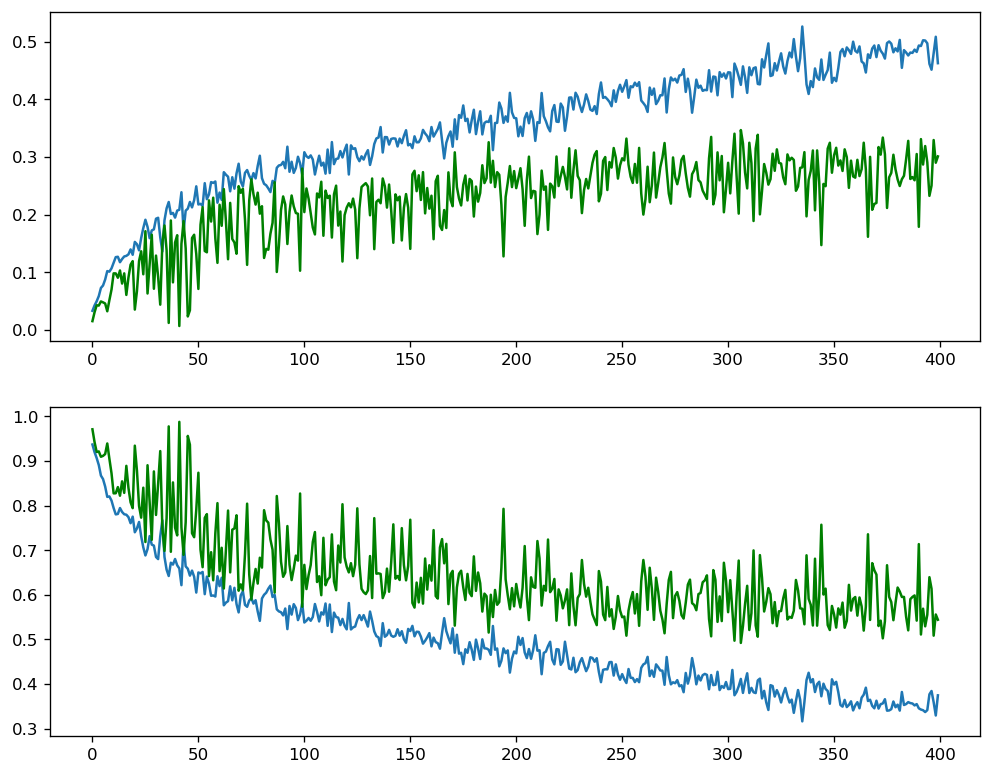

In [22]:
frame = pd.read_csv('../logs/Attention_Unet_2022-01-30_stone_161220/logs/train.csv')
fig, axes = plt.subplots(nrows = 2, ncols = 1, dpi = 120, figsize=(10,8))
axes[0].plot(frame['iou'])
axes[1].plot(frame['loss'])
frame = pd.read_csv('../logs/Attention_Unet_2022-01-30_stone_161220/logs/valid.csv')
axes[0].plot(frame['iou'],'green')
axes[1].plot(frame['loss'],'green')

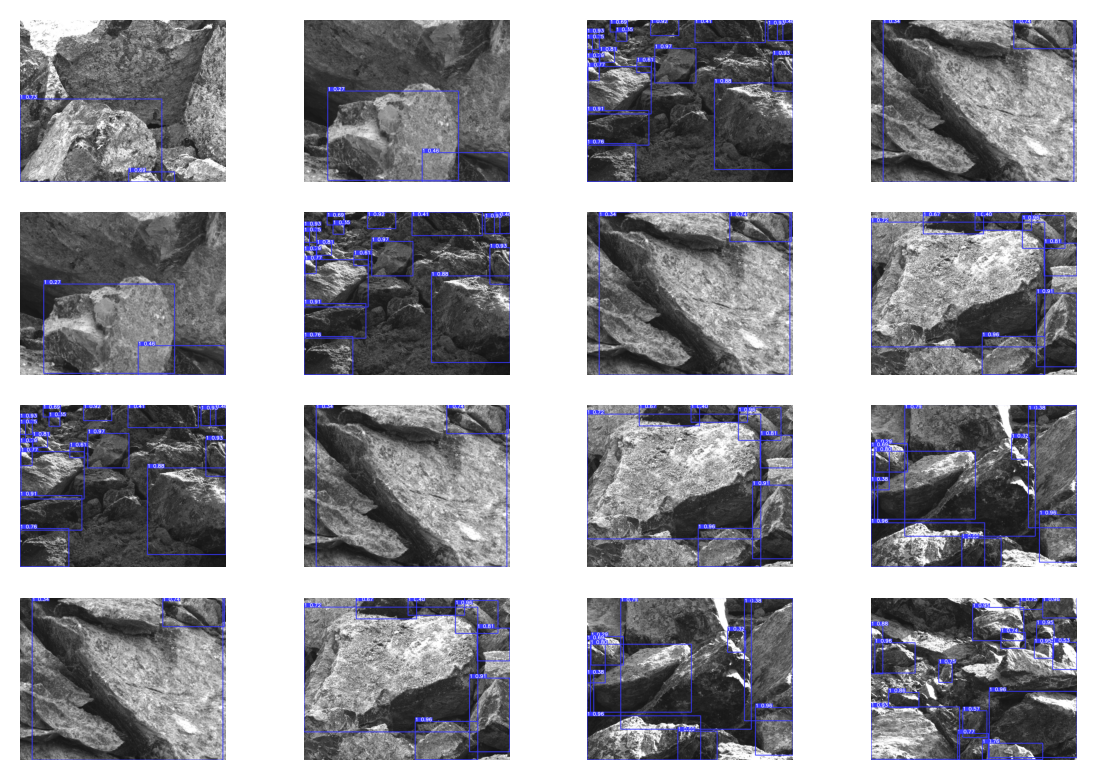

In [49]:
files = os.listdir('../yolov5/runs/detect/exp8')
image = cv.imread('../yolov5/runs/detect/exp8/'+files[10])
n = 4
fig,ax = plt.subplots(n,n, dpi = 200)
for i in range(n):
    for k in range(n):
        image = cv.imread('../yolov5/runs/detect/exp8/'+files[345+i+k])
        ax[i][k].imshow(image)
        ax[i,k].axis('off')
fig.tight_layout()